In [1]:
%pip install pathway bokeh --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
# %pip install bokeh

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.io import push_notebook
import time
output_notebook()

Loading BokehJS ...

In [4]:
import pandas as pd

# Load data
df = pd.read_csv("dataset.csv")

# Combine date and time
df['timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'], format='%d-%m-%Y %H:%M:%S')

# Rename columns for consistency
df.rename(columns={
    'SystemCodeNumber': 'lot_id',
    'Occupancy': 'occupancy',
    'Capacity': 'capacity',
    'QueueLength': 'queue_length',
    'VehicleType': 'vehicle_type',
    'TrafficConditionNearby': 'traffic',
    'IsSpecialDay': 'is_special_day',
    'Latitude': 'latitude',
    'Longitude': 'longitude'
}, inplace=True)

# Sort by time
df = df.sort_values(by='timestamp')

# Preview
display(df.head())

,ID,lot_id,capacity,latitude,longitude,occupancy,vehicle_type,traffic,queue_length,is_special_day,LastUpdatedDate,LastUpdatedTime,timestamp
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00,2016-10-04 07:59:00
5248,5248,BHMNCPHST01,1200,26.140014,91.731000,237,bike,low,2,0,04-10-2016,07:59:00,2016-10-04 07:59:00
3936,3936,BHMMBMMBX01,687,20.000035,78.000003,264,car,low,2,0,04-10-2016,07:59:00,2016-10-04 07:59:00
6560,6560,BHMNCPNST01,485,26.140048,91.730972,249,car,low,2,0,04-10-2016,07:59:00,2016-10-04 07:59:00
17056,17056,Shopping,1920,26.150504,91.733531,614,cycle,low,2,0,04-10-2016,07:59:00,2016-10-04 07:59:00


In [5]:
def baseline_linear_model(df, alpha=2.0, base_price=10):
    df = df.copy()
    df = df.sort_values(by="timestamp")
    df['price'] = base_price
    for i in range(1, len(df)):
        prev_price = df.loc[i - 1, 'price']
        occ_ratio = df.loc[i, 'occupancy'] / df.loc[i, 'capacity']
        df.loc[i, 'price'] = prev_price + alpha * occ_ratio
    return df

In [6]:
def demand_based_model(df, base_price=10, lambd=0.3):
    df = df.copy()
    df = df.sort_values(by="timestamp")

    # Feature Engineering
    df['occ_ratio'] = df['occupancy'] / df['capacity']
    df['queue_norm'] = df['queue_length'] / (df['queue_length'].max() + 1e-5)

    # Map traffic conditions to numerical values
    traffic_mapping = {'low': 1, 'average': 2, 'high': 3}
    df['traffic_numeric'] = df['traffic'].map(traffic_mapping)

    df['traffic_norm'] = df['traffic_numeric'] / (df['traffic_numeric'].max() + 1e-5)
    df['vehicle_weight'] = df['vehicle_type'].map({'car': 1.0, 'bike': 0.7, 'truck': 1.5})

    # Demand Function
    α, β, γ, δ, ε = 1.0, 0.8, 0.6, 0.9, 1.2
    df['demand'] = (
        α * df['occ_ratio'] +
        β * df['queue_norm'] -
        γ * df['traffic_norm'] +
        δ * df['is_special_day'] +
        ε * df['vehicle_weight']
    )

    # Normalize demand
    df['demand_norm'] = (df['demand'] - df['demand'].min()) / (df['demand'].max() - df['demand'].min() + 1e-5)

    # Price Calculation
    df['price'] = base_price * (1 + lambd * df['demand_norm'])
    df['price'] = df['price'].clip(lower=base_price * 0.5, upper=base_price * 2.0)

    return df


In [7]:
%pip install geopy

from geopy.distance import geodesic

def calculate_competitor_effect(row, df_all, radius_km=0.5):
    current_coord = (row['latitude'], row['longitude'])
    competitors = df_all[(df_all['lot_id'] != row['lot_id'])]

    # Calculate distance for each competitor and filter
    nearby = competitors[competitors.apply(
        lambda x: geodesic(current_coord, (x['latitude'], x['longitude'])).km <= radius_km, axis=1
    )].copy() # Add .copy() to avoid SettingWithCopyWarning

    if not nearby.empty:
        avg_price = nearby['price'].mean()
        if row['occupancy'] >= row['capacity']:
            if avg_price < row['price']:
                return -1  # reduce price or reroute
        elif avg_price > row['price']:
            return 1  # increase price slightly
    return 0  # no change

def competitive_pricing_model(df):
    df = demand_based_model(df)
    df['adjustment'] = df.apply(lambda row: calculate_competitor_effect(row, df), axis=1)
    df['price'] = df['price'] + df['adjustment'] * 0.5  # smooth adjustment
    df['price'] = df['price'].clip(lower=5, upper=20)
    return df

Note: you may need to restart the kernel to use updated packages.


In [8]:
def plot_price_trend(df, lot_id):
    df_lot = df[df['lot_id'] == lot_id].sort_values('timestamp')
    plt.figure(figsize=(12, 5))
    plt.plot(df_lot['timestamp'], df_lot['price'], label='Price')
    plt.title(f"Dynamic Pricing Trend for Lot {lot_id}")
    plt.xlabel("Time")
    plt.ylabel("Price ($)")
    plt.grid(True)
    plt.legend()
    plt.show()

C:\Users\taniy\AppData\Local\Temp\ipykernel_9920\2367219210.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '10.221837088388215' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i, 'price'] = prev_price + alpha * occ_ratio


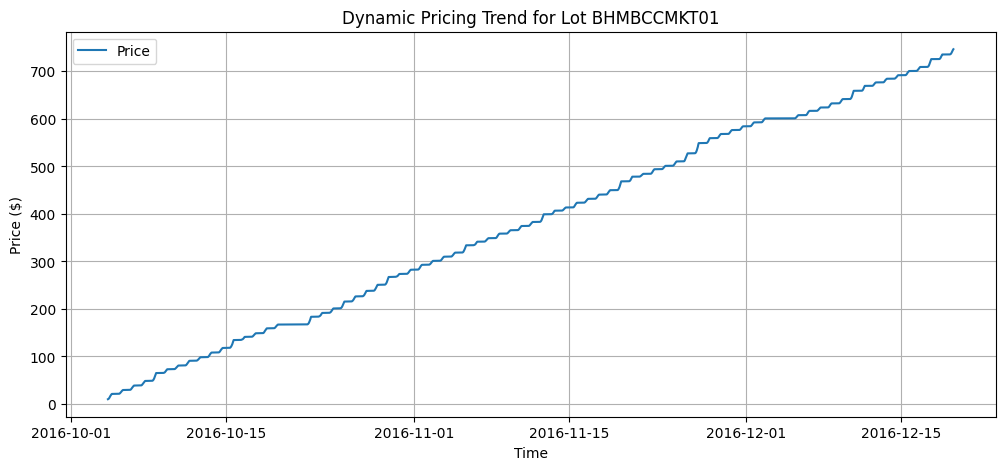

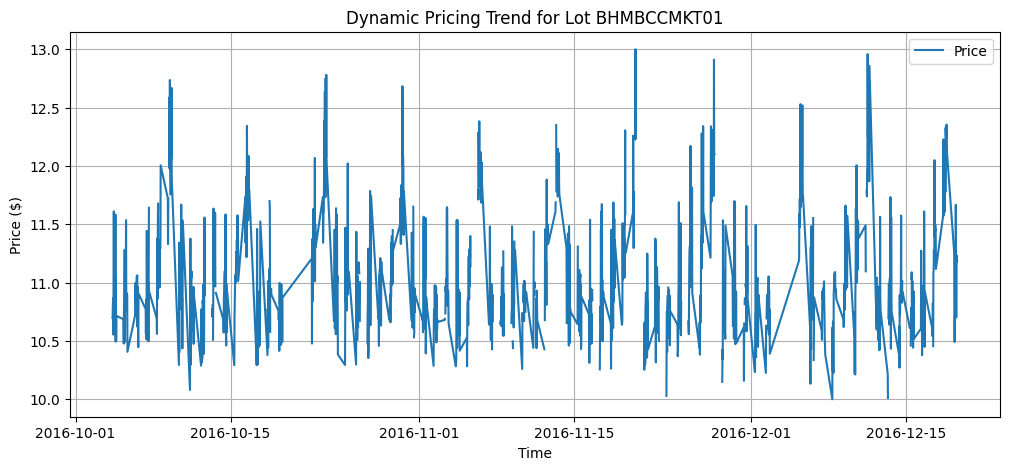

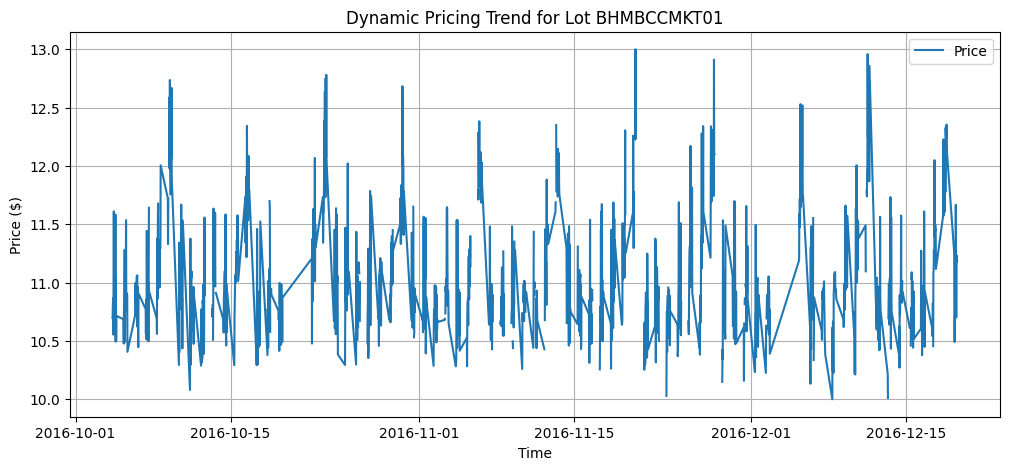

In [9]:
# Filter for one lot
lot_df = df[df['lot_id'] == df['lot_id'].unique()[0]]

# Model 1
baseline_df = baseline_linear_model(lot_df)
plot_price_trend(baseline_df, lot_df['lot_id'].iloc[0])

# Model 2
demand_df = demand_based_model(lot_df)
plot_price_trend(demand_df, lot_df['lot_id'].iloc[0])

# Model 3
competitive_df = competitive_pricing_model(lot_df)
plot_price_trend(competitive_df, lot_df['lot_id'].iloc[0])

In [10]:
def demand_based_model(df, base_price=10, lambd=0.3):
    df = df.copy()
    df = df.sort_values(by="timestamp")

    # Feature Engineering
    df['occ_ratio'] = df['occupancy'] / df['capacity']
    df['queue_norm'] = df['queue_length'] / (df['queue_length'].max() + 1e-5)

    # Map traffic conditions to numerical values
    traffic_mapping = {'low': 1, 'average': 2, 'high': 3}
    df['traffic_numeric'] = df['traffic'].map(traffic_mapping)

    df['traffic_norm'] = df['traffic_numeric'] / (df['traffic_numeric'].max() + 1e-5)
    df['vehicle_weight'] = df['vehicle_type'].map({'car': 1.0, 'bike': 0.7, 'truck': 1.5})

    # Demand Function
    α, β, γ, δ, ε = 1.0, 0.8, 0.6, 0.9, 1.2
    df['demand'] = (
        α * df['occ_ratio'] +
        β * df['queue_norm'] -
        γ * df['traffic_norm'] +
        δ * df['is_special_day'] +
        ε * df['vehicle_weight']
    )

    # Normalize demand
    df['demand_norm'] = (df['demand'] - df['demand'].min()) / (df['demand'].max() - df['demand'].min() + 1e-5)

    # Price Calculation
    df['price'] = base_price * (1 + lambd * df['demand_norm'])
    df['price'] = df['price'].clip(lower=base_price * 0.5, upper=base_price * 2.0)

    return df

In [11]:
def simulate_bokeh_stream(df, lot_id):
    df = df[df['lot_id'] == lot_id].sort_values('timestamp')
    df = demand_based_model(df)

    source = ColumnDataSource(data=dict(timestamp=[], price=[]))

    p = figure(title=f"Live Pricing – Lot {lot_id}", x_axis_type='datetime', width=800, height=300)
    p.line(x='timestamp', y='price', source=source, line_width=2, color='navy')
    handle = show(p, notebook_handle=True)

    for i in range(len(df)):
        new_data = {
            'timestamp': [df.iloc[i]['timestamp']],
            'price': [df.iloc[i]['price']]
        }
        source.stream(new_data, rollover=200)
        push_notebook(handle=handle)
        time.sleep(0.1)

In [12]:
simulate_bokeh_stream(df, lot_id=df['lot_id'].unique()[0])

In [13]:
%%capture
import pathway as pw
pw.run()
# %pip install -U pathway

AttributeError: module 'pathway' has no attribute 'run'
This is not the real Pathway package.
Visit https://pathway.com/developers/ to get Pathway.
Already tried that? Visit https://pathway.com/troubleshooting/ to get help.
Note: your platform is Windows-11-10.0.26100-SP0, your Python is CPython 3.12.4.